<a href="https://colab.research.google.com/github/ecuadrafoy/PracticalMachineLearning/blob/master/ReinforcedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using `tf_agents` to train a Deep Q Network

* `tf_agents` is a library for RL based on Tensorflow. 
* TF- agents runs on TensorFlow 2.2.0 and 
* The Deep Q Newtork algorith, developed in 2015 enhanced a classic Q-Learning algorithm with deep neural netowkrs and a technique called experience replay.
* The Q-function of a policy $\pi$ measures the expected return or discounted sum of rewards obtained from the state $s$ by taking action $a$ frist and following policy $\pi$ thereafter.  Optimal Q-function is defined as $Q^*(s,a)$ as the maximum return that can be obtained starting from observation *s*, taking action *a* and following the optimal policy thereafter.
* *S* is the set of states. At each time step *t*, the agents gets the environment's state - *St*, where *St* $\epsilon$ *S*
* *A* is a set of actions that the agent can do in defined state. The agent makes the decision to perform an action, based on the state *St* - *At* where *At* $\epsilon$ *A(St)*. *A(St)* represents a set of possible actions in the state *St*

* The optimal Q-function obeys the following optimality equation:

$\begin{equation}Q^\ast(s, a) = \mathbb{E}[ r + \gamma \max_{a'} Q^\ast(s', a') ]\end{equation}$

This means that the maximum return from state $s$ and action $a$ is the sum of the immediate reward $r$ and the return (discounted by $\gamma$) obtained by following the optimal policy therafter until the end of the episode

* The discount factour $\gamma$ determines how much importance we want to give to future rewards.

* To avoid computing the full expectation in the DQN loss, it can be minimized using stochastic gradient descent. If the loss is computed using just the last transition $\{s, a, r, s'\}$, this reduces to standard Q-Learning. 

* At each time step of data collection, the transitions are added to a circular buffer called the *replay buffer*. Then during training, instead of using just the latest transition to compute the loss and its gradient, it is computed using a mini-batch of transitions sampled from the replay buffer




## Setting up Packages

* This experiments implements a DQN agent as developed by Mnhi et al. 2015. 

In [1]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 784 kB in 0s (7,165 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requir

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

## Create the environment
* An environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites
* In CartPole we have a cart with a pole on top of it. The mission is to learn to keep up the pole moving the cart left and right. 
* The enviroment from suite_gym includes a slightly customized version that is optimized for its use with TF-Agents
* `TFPyEnvironment()` converts numpy arrays for state observations, actions and rewards into TensorFlow tensors. 



In [3]:
env = suite_gym.load('CartPole-v1')

env = tf_py_environment.TFPyEnvironment(env)

In [4]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [6]:
env.reset()
#PIL.Image.fromarray(env.render())

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.02739406, -0.03622656,  0.03145718,  0.04715188]],
      dtype=float32)>)

* The `environment.step` method takes an action in the environment and returns a `TimeStep` tuple containing the next observation of the enviroment and the reward for the action

* The `time_step_spec()` method returns the specification of the `TimeStep` tuple. Its observation attribute shows the shape of observations, the data types, and the ranges of allowed values. reward attribute shows the same details for the reward

* The `action_spec()` method returns the shape, data types and allowed values of valid actions



In [7]:
print('Observation Spec:')
env.time_step_spec().observation

Observation Spec:


BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32))

In [8]:
print('Reward Spec:')
env.time_step_spec().reward

Reward Spec:


TensorSpec(shape=(), dtype=tf.float32, name='reward')

In [9]:
print('Action Spec:')
env.action_spec()

Action Spec:


BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))

## Agent

* There are different agents in TF-Agents. Here DQN will be used.
* One of the main parameters of the agents is its Q neural network which will be used to calculate Q-values for the actions in each step.
* A Q network has to parameters, input_tensor_spec and action_spec which define observation shape and the action shape
* The agent also requires an optimizer to find the values for the Q network parameter

In [10]:
q_net = q_network.QNetwork(env.observation_spec(), 
                           env.action_spec())

In [11]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

The agent is defined and initialized with the following

* `time_step_spec` that is obtained from the environment and defines how time steps are defind
* `action_spec`
* The Q network created prior
* The optimizer
* Train step counter that is a rank 0 tensor which will count the number of steps done on the environment.

In [12]:
train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(env.time_step_spec(),
                           env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           td_errors_loss_fn= 
                                  common.element_wise_squared_loss,
                           train_step_counter=train_step_counter)
agent.initialize()


* The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

* The following function computes the average return of a policy, given the policy, environment, and a number of episodes.

In [13]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(env, agent.policy, 5)
returns = [avg_return]

* As described previously, one of the breakthroughs of DQN was experience replay, in which the experiences of the agent (state, action, reward) are stored and used to train the Q network in batches in each step
* TF-Agents include the object `TFUniformReplayBuffer` which stores these experiences to re-use them later.
* In this method, an environment, a policy and a buffer are taken, the current time_step is formed by its state observation and reward at that time_step, the action the policy chooses and then the next time_step. This is then stored in the replay buffer. 


In [14]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                                data_spec=agent.collect_data_spec,                                                                
                                batch_size=env.batch_size,                                                              
                                max_length=100000)

## Policies

* A policy defines the way an agent acts in an environment. The goal of RL is to train the model until the policy produces the desired outcome.
  * The goal of CartPole is to keep the pole balanced upright over the cart
  * The policy returns an action for each `time_step` observation
* Agents contain two policies
  * `agent.policy` the main policy used for evaluation and deployment
  * `agent.collect_policy` a second policy used for data collection

* Policies can be created independent of agents using `random_tf_policy` to create a policy which will randomly select an action for each `time_step`

In [15]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())




* The collect_step executes the random policy in the environment for a few steps and records the data in the replay buffer. 

In [16]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)


## Training the Agent

* The number of steps made will be defined and after this number of steps the agent will be trained in every iteration, modifying its policy. 

* the batch size is define with which the Q network will be trained and the iterator is used so that it can iterate over the experience of the agent. 

* Get experience by acting on the environment, train policy and repeat

* The loss and the performance are printed every 200 and 1000 steps respectively. 

In [17]:
collect_steps_per_iteration = 1
batch_size = 64
dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                   sample_batch_size=batch_size, 
                                   num_steps=2).prefetch(3)
iterator = iter(dataset)
num_iterations = 20000
env.reset()
for _ in range(batch_size):
    collect_step(env, agent.policy, replay_buffer)
for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(env, agent.collect_policy, replay_buffer)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    # Print loss every 200 steps.
    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
    # Evaluate agent's performance every 1000 steps.
    if step % 1000 == 0:
        avg_return = compute_avg_return(env, agent.policy, 5)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 12.630553245544434
step = 400: loss = 2.316990375518799
step = 600: loss = 0.38659077882766724
step = 800: loss = 3.7462635040283203
step = 1000: loss = 1.9752943515777588
step = 1000: Average Return = 84.5999984741211
step = 1200: loss = 115.80011749267578
step = 1400: loss = 54.5186653137207
step = 1600: loss = 66.94447326660156
step = 1800: loss = 37.08972930908203
step = 2000: loss = 347.9102783203125
step = 2000: Average Return = 53.599998474121094
step = 2200: loss = 162.85171508789062
step = 2400: loss = 591.3302001953125
step = 2600: loss = 1506.765869140625
step = 2800: loss = 542.5953369140625
step = 3000: loss = 4155.16015625
step = 3000: Average Return = 182.39999389648438
step = 3200: loss = 6408.60595703125
step = 3400: loss = 2877.0576171875
step = 3600: loss = 2520.786865234375
step = 3800: loss = 3660.02294921875
step = 4000: loss = 613.3059692382812
step = 4000: Average Return = 152.8000030517578
step = 4200: loss = 3717.43603515625
step = 4400: los

Text(0.5, 0, 'Iterations')

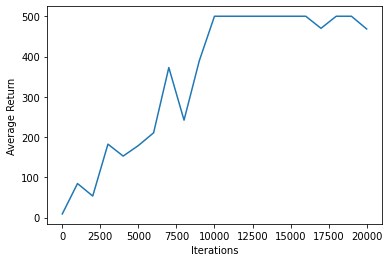

In [18]:
iterations = range(0, num_iterations + 1, 1000)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')